# 1. Introduction

Graphene blocks are comprised of two major data structures, an Invertible Bloom Lookup Table (IBLT) labeled $I$ and a Bloom filter (BF) labeled $B$.
In this document we analyze two size tuning procedures for Graphene blocks. Although the [original Graphene paper](https://people.cs.umass.edu/~gbiss/graphene.pdf) offered an optimization formula, the current version (as of commit 786c1d1) uses brute-force search to find optimal sizes for $I$ and $B$. This decision was made because the optimization formula is unable to account for discontinuous functions such as floors and ceilings. As a result, the formula is inaccurate, particularly for Graphene blocks containing relatively few transactions. Nevertheless, for large blocks, the formula should work quite well, and is much more efficient than brute-force search. Therefore, one of the goals of this document is to determine the conditions necessary for the optimization formula to work well.

The second goal of this document is to determine a suitable increase in the size of $I$ that can compensate for the natural variance in the false positive rate (FPR) of $B$. It is relatively easy to determine the expected number of false positives (FPs) for a BF of given size and holding a given number of items. However, some fraction of the time, more FPs will be generated than expected. In such cases we want $I$ to be large enough to decode.

# 2. Optimization formula

There are two sources of error that must be accounted for when sizing $I$ and $B$: 

1. Transactions $M$ that are in the block but missing from the receiver mempool. 
2. Transactions $S$ that are not the block but are in the receiver mempool and which pass through the $B$ as FPs. 

$I$ must be sized large enough so that all transactions in $M \cup S$ can be recovered. Define $E$ to be the set of *excess transactions* that are in the receiver mempool, but not in the block. If $f_B$ is the FPR for $B$, then in expectation, $f_B |E| = |S|$. It is not possible for the sender to control $M$, but the size of $S$ is completely in his control. By reducing the FPR of $B$, the sender can make $S$ arbitrarily small, reducing the required size of $I$. However reducing the FPR of $B$ also requires an increase in the size of $B$. 

Thus, optimizing Graphene block size can be accomplished by determining the ideal choice for $s = |S|$, which leads to a minimal combined size for $I$ and $B$. Working with the actual sizes for $I$ and $B$, that arise from their c++ implementations, along with a simplified definition of FPR $f_B$ that ignores floors and ceilings, we can develop an expression for total size $T$. We begin with a table of variables.

| variable | description |
|:--------:|-------------|
| $k$ | number of hash functions in $I$ |
| $b$ | BF cell size (bytes)|
| $n$ | items in block |
| $i$ | IBLT cell size (bytes) |
| $v$ | IBLT overhead |
| $M$ | Missing transactions as defined above |
| $S$ | False positives as defined above |
| $E$ | Excess transactions in mempool |
| $s$ | size of $S$, $|S|$
| $f_B(s)$ | implied FPR of $B$ given $s$ | 
| $I(s)$ | Size of $I$ given $s$ |
| $B(s)$ | Size $B$ given $s$ |
| $T(s)$ | Aggregate size of $I$ and $B$ given s| 

Based on the definitions above, we have the following exact sizes based on the current C++ implementation of Graphene.

$$f_B(s, |E|) = \frac{s}{|E|}$$
$$B'(s, |E|, n) = \left \lfloor \frac{b n}{8} \left( \frac{-1}{\ln^2(2)} \right) \right \rfloor \ln(f_B(s, |E|))$$
$$I'(s) = i k \lceil \lceil v s \rceil / k \rceil$$
$$T'(s, |E|, n) =  I'(s, k) + B'(s, |E|, n)$$

And after removing floor and ceiling functions, we the following continuous approximations.

$$f_B(s, |E|) = \frac{s}{|E|}$$
$$B(s, |E|, n) = \frac{b n}{8} \left( \frac{-1}{\ln^2(2)} \right) \ln(f_B(s, |E|))$$
$$I(s) = i v s$$
$$T(s, |E|, n) =  I(s) + B(s, |E|, n)$$

Taking the derivative of $T(s)$ with respect to $s$ and setting the result equal to zero, we can solve for the optimal value of $s$ assuming a continuous size model:

$$s^* = \texttt{round}\left( \frac{bn}{8iv \ln^2(2)} \right).$$

In the code below, we analyze the accuracy of the continuous model, relative to the exact solution, for various block sizes $n$ where the number of excess transaction in the mempool $e$ varies as a function of $n$.

## 2.1 Variable IBLT cell size

Some implementations of Graphene feature a variable IBLT cell size, which complicates the derivation of the optimal (continuous) solution. In this section, we refine the optimal solution presented in the section above to the scenario where the number of bits in the IBLT cell checksum can vary. This scenario is described in detail in a [separate analysis](https://github.com/bissias/graphene-experiments/blob/master/jupyter/min_checksum_IBLT.ipynb). From that analysis, we have that the number of checksum bits $\beta^*$ necessary to ensure an error rate no greater than $\tau$ is give by the following.
$$
\beta^* = \log_2 \left( sv \left[1 - \left(1 - f_B(s) \frac{k}{sv}\right)^m\right] \right) - \log_2(\tau),
$$
where $m$ is the size of the receiver's mempool.

When using $\beta^*$ bits for the checksum, the total IBLT cell size is equal to the sum of $\beta^*$ bits, 4 bytes for the count field, 8 bytes for the key, and 1 byte for the value (it is always empty so this is just the overhead for an empty vector). That is to say
$$
i = \frac{\beta^*}{8} + 13.
$$
Notice that the formula for optimal bits $\beta^*$ is a function of both $s^*$ and $f_B$. But $s^*$ is itself a function of $i$ (ultimately $\beta^*$) and $f_B$ is a function of $s^*$. Therefore, we have a system of 3 equations and as many unknowns that must be solved. Unfortunately, two of these equations are are nonlinear and overall the system is difficult to solve. So instead we opt for an iterative solution. First, $s^*$ and $f_B(s^*)$ are constructed under the assumption that $\beta = 32$. Then, we solve for $\beta^*$ given the previous values for $s^*$ and $f_B(s^*)$. Finally, $s^*$ and $f_B(s^*)$ can be recomputed using the latest value for $\beta^*$. At this point we can either terminate the process, satisfied with an approximate solution, or continue for more iterations until all values reach a fixed point. 

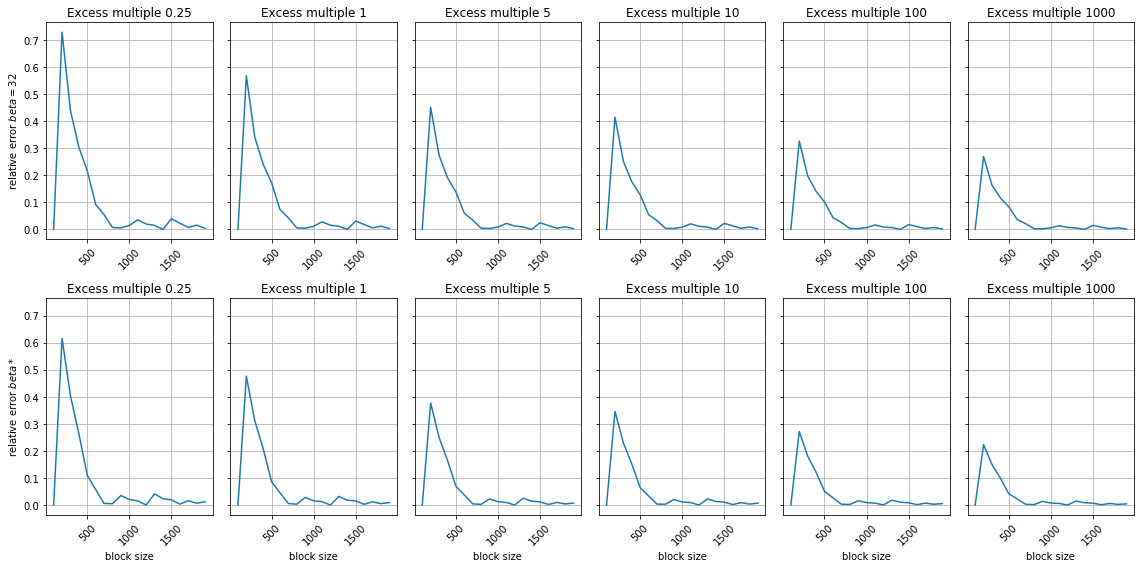

In [22]:
# setup
from collections import defaultdict
import numpy as np
import pylab as plt
import re
import requests
import sys

np.seterr(all='raise')

# Actual values in c++ implementation
i_default = 17; b = 1; v_default = 1.5; k = 4; tau = 0.001
response = requests.get('https://raw.githubusercontent.com/BitcoinUnlimited/\
BitcoinUnlimited/release/src/iblt_params.h')
matches = re.findall('{(.*?), IbltParamItem\((.*?), (.*?)\)}', response.text)
s_v_map = defaultdict(lambda: 1.5)
s_k_map = defaultdict(lambda: 4)
for match in matches:
    s_v_map[int(match[0])] = float(match[1])
    s_k_map[int(match[0])] = int(match[2])

def f_B(s, e): return 1.0 if s > e or e == 0 else s / e
def Bp(s, e, n): return np.floor(b * n / 8.0 * (-1 / np.log(2)**2) * np.log(f_B(s, e)))
def B(s, e, n): return b * n / 8.0 * (-1 / np.log(2)**2) * np.log(f_B(s, e))
def Ip(s, i): return i * s_k_map[s] * np.ceil(int(s_v_map[s] * s) / s_k_map[s])
def I(s, i): return i * s_v_map[s] * s
def Tp(s, e, n, i): return Ip(s, i) + Bp(s, e, n)
def T(s, e, n, i): return I(s, i) + B(s, e, n)
def s_opt(n, i): return max(1, round(b * n / (8 * i * v_default * np.log(2)**2)))
def opt_bits(s, v, f, k, m, tau):
    return np.log2(s * v * (1 - (1 - f*k/(s*v))**m)) - np.log2(tau)

def brute_best(n, e, i):
    best_s = None
    best_T = sys.maxsize
    for s in range(1, n+1):
        t = Tp(s, e, n, i)
        if t < best_T:
            best_T = t
            best_s = s
            
    return best_s

# vary e with n
rows, cols = 2, 6
f, axes = plt.subplots(rows, cols, sharey=True, figsize=(16,8))
ns = list(range(100,2000,100))
mults = [0.25, 1, 5, 10, 100, 1000]
for row in [0,1]:
    for col, idx in enumerate(range(len(mults))):
        lines = []
        mult = mults[idx]
        
        if row == 0: # checksum bits fixed at 32
            T_discs = {n: Tp(brute_best(n, n*mult, i_default), n*mult, n, i_default) for n in ns}
            T_conts = {n: Tp(s_opt(n, i_default), n*mult, n, i_default) for n in ns}
            diffs = [min(1, (T_conts[n] - T_discs[n])/ T_discs[n]) for n in ns]
        else: # checksum bits vary
            T_discs_default = {}; T_conts_default = {}
            for n in ns:
                s_star = s_opt(n, i_default)
                beta = opt_bits(s_star, v_default, f_B(s_star, n*mult), k, n*mult, tau)
                i = beta / 8 + 13
                T_discs[n] = Tp(brute_best(n, n*mult, i), n*mult, n, i)
                T_conts[n] = Tp(s_opt(n, i), n*mult, n, i)
            diffs = [min(1, (T_conts[n] - T_discs[n])/ T_discs[n]) for n in ns]
    
        line = axes[row, col].plot(ns, diffs)
        lines.append(line)
        axes[row, col].grid(True)
        axes[row, col].set_title('Excess multiple ' + repr(mult))
        plt.setp(axes[row, col].get_xticklabels(), rotation=45)
        if col == 0 and row == 0: axes[row, col].set(ylabel='relative error $beta = 32$')
        if col == 0 and row == 1: axes[row, col].set(ylabel='relative error $beta *$')
        if row == rows-1: axes[row, col].set(xlabel='block size')
plt.tight_layout()

## 2.1 Analysis of Optimization Formula

In the previous section, we showed that $s^*$ is the best choice for $s$ assuming a continuous model of data structure sizes. Let $s'$ denote the overall best choice for $s$, using actual sizes. The top row of plots above show the relative error between $T'(s',\ldots)$ and $T'(s^*,\ldots)$ when $\beta=32$ bits per hash are used for the IBLT cell checksum. The bottom row shows the same but where $\beta = \beta^*$ (as calculated in Section 2.1.

From the plots, we can see that for $n > 200$, the relative error is (roughly) decreasing with both $n$ and $e$. The increase in error for small $n$ arises from the disparity in optimal overhead (as defined [here](https://github.com/BitcoinUnlimited/BitcoinUnlimited/blob/92151fb2ad7489c1229b5d05e80c5a4dc5cef53d/src/iblt_params.h#L44)) and the asymptotic estimate of 1.5, which is used in the calculation of $s^*$. Assuming that we can tolerate as much as a 10% increase in block size for small blocks, and using the plots as a guide, the continuous solution $s'$ is a reasonable choice for $n \geq 600$ and $e \geq n / 4$ when $\beta = 32$, and it is a reasonable choice for $n \geq 500$ and $e \geq n / 4$ when $\beta = \beta^*$.

# 3. Bounding False Positives

The second objective of this document is to place an upper bound on the number of false positives (FPs) passing through Bloom filter $B$, even accounting for tail-events that occur with low probability. In a [forthcoming publication](http://cryptoeconomics.cs.umass.edu/buip093/draft.pdf), we derived a Chernoff bound on the probability that the actual number of FPs exceeds a given value. Let $s^*$ be the ideal choice for the *average* number of FPs, as defined in the previous section. With probability $p$, the number of FPs will not exceed $s^*(1+\delta^*)$  when $\delta^*$ is defined as

$$
\delta^* = \frac{1}{2} (q + \sqrt{q^2 + 8q})
$$
and,
$$
q = -\frac{\ln(1-p)}{s^*}
$$.

The consequence of this result is that IBLT $I$ must be padded by $\Delta s^* = \lceil s^* \delta^* \rceil$ cells in order to ensure that the probability it fails to decode due to an unexpectedly high number of FPs is less than $1-p$.

In the code below, we show how $\Delta s^*$ changes for various block sizes $n$ and success rate $p$. In particular, we plot the ratio $\Delta s^* / I(s^*)$, which is the number additional cells that need be added to the IBLT relative to the optimal size of the IBLT before accounting for variance in $B$. For simplicity, we use the continuous optimum $s^*$ in this analysis, but the overall optimal value $s'$ can be used as well.

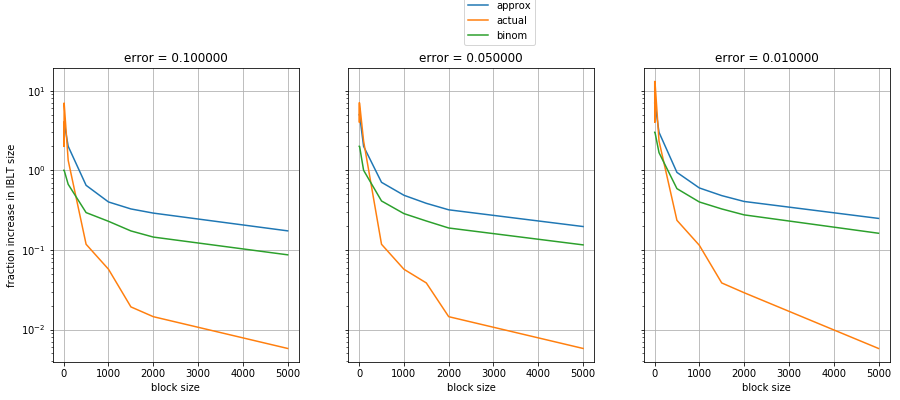

In [104]:
from scipy.stats import binom
error_csv = """nItems,nExcess,delta,fpr,targetError,error
1,10000,25.6,1.02028e-05,0.1,0.091
1,10000,51.2,1.02028e-05,0.05,0.044
1,10000,102.4,1.02028e-05,0.01,0.007
2,10000,12.8,6.9379e-05,0.1,0.039
2,10000,12.8,6.9379e-05,0.05,0.044
2,10000,51.2,6.9379e-05,0.01,0.001
3,10000,3.2,0.000104068,0.1,0.045
3,10000,6.4,0.000104068,0.05,0.007
3,10000,6.4,0.000104068,0.01,0.004
4,10000,1.6,0.000138758,0.1,0.091
4,10000,6.4,0.000138758,0.05,0.009
4,10000,12.8,0.000138758,0.01,0
5,10000,1.6,0.000173447,0.1,0.078
5,10000,3.2,0.000173447,0.05,0.05
5,10000,6.4,0.000173447,0.01,0.009
6,10000,3.2,0.000208137,0.1,0.022
6,10000,3.2,0.000208137,0.05,0.041
6,10000,6.4,0.000208137,0.01,0.006
7,10000,1.6,0.000242826,0.1,0.085
7,10000,3.2,0.000242826,0.05,0.019
7,10000,6.4,0.000242826,0.01,0.001
8,10000,3.2,0.000277516,0.1,0.009
8,10000,3.2,0.000277516,0.05,0.018
8,10000,3.2,0.000277516,0.01,0.01
9,10000,3.2,0.000312205,0.1,0.051
9,10000,3.2,0.000312205,0.05,0.041
9,10000,6.4,0.000312205,0.01,0.006
10,10000,6.4,0.000102028,0.1,0.022
10,10000,6.4,0.000102028,0.05,0.016
10,10000,12.8,0.000102028,0.01,0
100,1000,3.2,0.00102028,0.1,0.075
100,1000,6.4,0.00102028,0.05,0.003
100,1000,6.4,0.00102028,0.01,0.004
500,1000,1.6,0.00510139,0.1,0.056
500,1000,1.6,0.00510139,0.05,0.046
500,1000,3.2,0.00510139,0.01,0
1000,1000,1.6,0.0102028,0.1,0.003
1000,1000,1.6,0.0102028,0.05,0.01
1000,1000,3.2,0.0102028,0.01,0
1500,1000,0.8,0.0153042,0.1,0.093
1500,1000,1.6,0.0153042,0.05,0.005
1500,1000,1.6,0.0153042,0.01,0.005
2000,1000,0.8,0.0204056,0.1,0.052
2000,1000,0.8,0.0204056,0.05,0.045
2000,1000,1.6,0.0204056,0.01,0.001
5000,1000,0.4,0.173447,0.1,0.007
5000,1000,0.4,0.173447,0.05,0.005
5000,1000,0.4,0.173447,0.01,0.009"""
raw_rows = error_csv.split('\n')
header = raw_rows.pop(0).split(',')
csv_rows = []
for raw_row in raw_rows:
    row = {}
    for i, field in enumerate(raw_row.split(',')):
        row[header[i]] = float(field)
    csv_rows.append(row)

def delta(s, p):
    q = - np.log(1-p) / s
    
    return 0.5 * (q + np.sqrt(q**2 + 8*q))

def delta_s(s, p):
    return np.ceil(s * delta(s,p))

rows, cols = 1, 3
f, axes = plt.subplots(rows, cols, sharey=True, sharex=True, figsize=(15,cols*1.8))
ns = [4, 5, 6, 7, 8, 9, 10, 100, 500, 1000, 1500, 2000, 5000]
n_fpr_map = {n: f_B(s_opt(n), 1000) for n in ns}
ps = [0.1, 0.05, 0.01]
csv_rows = [row for row in csv_rows if row['nItems'] in ns]
for idx in range(len(ps)):
    p = ps[idx]
    binom_deltas = [binom.ppf(1-p, 1000, n_fpr_map[n]) / s_opt(n) - 1 for n in ns]
    actual_deltas = [np.ceil(row['delta'])/s_opt(row['nItems']) for row in csv_rows if row['targetError'] == p]
    row = idx // cols
    col = idx % cols
    delta_ss = [delta_s(s_opt(ns[i]), 1-p)/s_opt(ns[i]) for i in range(len(ns))]
    line_approx, = axes[col].semilogy(ns, delta_ss)
    line_actual, = axes[col].semilogy(ns, actual_deltas)
    line_binom, = axes[col].semilogy(ns, binom_deltas)
    axes[col].set_title('error = %f' % p)
    axes[col].grid(True)
    if col == 0: axes[col].set(ylabel='fraction increase in IBLT size')
    if row == rows-1: axes[col].set(xlabel='block size')
    
legend = f.legend([line_approx, line_actual, line_binom], ('approx', 'actual', 'binom'), 'upper right', bbox_to_anchor=(0.5, 1.05))
plt.show()

The plot above compares the theoretical bound (in blue) on the required increase in IBLT size $\Delta s^*$ to the actual required size $\Delta s'$ (shown in orange). Each facet corresponds to a different error rate achieved. To generate data for $\Delta s'$ we first determined the optimal FPR for the given block size using $f_B(s^*)$ from above, then we instantiated Bloom filters for each $n$ and associated FPR, and varied $\Delta s'$ until the actual fraction of FPs was below the indicated error rate. The code can be found [here](https://github.com/bissias/BitcoinUnlimited/blob/601099dc17a40cc4c5a6fa8ddc90f5bb1738d42c/src/test/bloom_tests.cpp#L1026).

It is interesting to note that agreement between the theoretical bound and the empirically derived values for $\Delta s$ is not particularly good. The bound is an approximation based on the assumption that FPs in $B$ are generated at a uniform rate equal to the FPR, which would imply the number of FPs follow a binomial distribution with mean $s$. If this assumption is true, calculating the expected number of FPs that occur with probability $p$ would amount to finding the $p$th percentile of the binomial distribution. The bound provided by the blue curve is actually an upper bound on this percentile. Thus, it is possible that error arises either from the binomial assumption, or from the approximation of the bound given the assumption. To differentiate between the two, we also plotted (in green) the required increase in $\Delta s$ corresponding the actual $p$th percentile of the binomial with mean $s$. What we can see is that the bound in blue is quite close to the binomial model in green, while neither are close to the empirical result in orange. This is implies that the model itself is not very accurate, particularly for large $n$.

<!--Going forward, we use $\delta$ to indicate the fraction increase in IBLT size that we will choose for our Graphene implementation. Similarly, let $s$ be the expected number of false positives used in the implementation. From the analysis above, we know that the optimal value $s'$ will be used for small $n$ and the approximate optimal value $s^*$ will be used otherwise. Furthermore, we define $\Delta s$ as the number of cells that will be added to IBLT; i.e. the total size will be $I(s) + \Delta(s) = I(s(1 + \delta))$.-->

Because the bound appears to be quite weak for large block sizes $n$, we choose to use computed values instead of theoretical values in the implementation. We opt to ensure a 95% success rate, which our experiment indicates can be accomplished by choosing $\delta$ from the following table.

|$n$|$\delta$|
|---|---|
|1|51.2|
|2|12.8|
|3|6.4|
|4|6.4|
|5|3.2|
|6|3.2|
|7|3.2|
|8|3.2|
|9|3.2|
|10-100|6.4|
|100-500|6.4|
|500-1000|1.6|
|1000-1500|1.6|
|1500-2000|1.6|
|2000-5000|0.8|
|5000-|0.4|